In [13]:
import os
import re
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, mean_absolute_error, mean_squared_error, r2_score
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
print("Libraries loaded")

# Create directory to save models and encoders
os.makedirs('models', exist_ok=True)

Libraries loaded


In [14]:
# CELL 2 - Load Data and Feature Engineering

# NOTE: Ensure 't20i_Matches_Data_final.csv' is in the same directory as this notebook
DATA_PATH = 't20i_Matches_Data_final.csv'
df = pd.read_csv(DATA_PATH)
print("Dataset loaded. shape:", df.shape)

# Rename columns for ease of use (based on your CSV structure)
safe_map = {
    'Team1 Name': 'team1',
    'Team2 Name': 'team2',
    'Match Venue (Stadium)': 'venue_stadium',
    'Toss Winner': 'toss_winner_id',
    'Match Winner': 'winner_id',
    'Team1 Runs Scored': 'team1_runs_norm', 
    'Team2 Runs Scored': 'team2_runs_norm', 
    'Toss Winner Choice_bat': 'toss_choice_bat',
    'Toss Winner Choice_bowl': 'toss_choice_bowl',
}
df = df.rename(columns=safe_map)
dfp = df.copy()

# Feature Engineering for Model Targets
MAX_SCORE = 250 # Assumed max T20I score for denormalization
dfp['team1_runs'] = dfp['team1_runs_norm'] * MAX_SCORE
dfp['team2_runs'] = dfp['team2_runs_norm'] * MAX_SCORE

# Target 3: Safe Score (Regression) - approximated as the maximum score recorded in the match
dfp['first_innings_score_num'] = dfp[['team1_runs', 'team2_runs']].max(axis=1)

# Target 1: Match Winner (Classification) - Normalize winner ID
def normalize_winner(row):
    w_id = row['winner_id']
    if w_id == row['team1']: return str(row['team1'])
    if w_id == row['team2']: return str(row['team2'])
    return str(w_id)
dfp['winner_norm'] = dfp.apply(normalize_winner, axis=1)

# Target 2: Toss Decision (Classification)
dfp['toss_decision'] = np.where(dfp['toss_choice_bat'] == True, 'bat', 'bowl')

# Prepare categorical features as strings (The numerical IDs are treated as categories)
dfp['venue'] = dfp['venue_stadium'].astype(str)
dfp['team1'] = dfp['team1'].astype(str)
dfp['team2'] = dfp['team2'].astype(str)
dfp['toss_winner_id'] = dfp['toss_winner_id'].astype(str) 

# Final cleanup
dfp = dfp.dropna(subset=['team1','team2','venue', 'winner_norm', 'toss_decision', 'first_innings_score_num']).reset_index(drop=True)
print("After feature engineering and cleaning, shape:", dfp.shape)

Dataset loaded. shape: (2591, 14)
After feature engineering and cleaning, shape: (2591, 20)


Original feature space: 426 features
Reduced PCA feature space (95% variance): 350 components
Cumulative Explained Variance: 0.9500
Starting t-SNE visualization on a sample


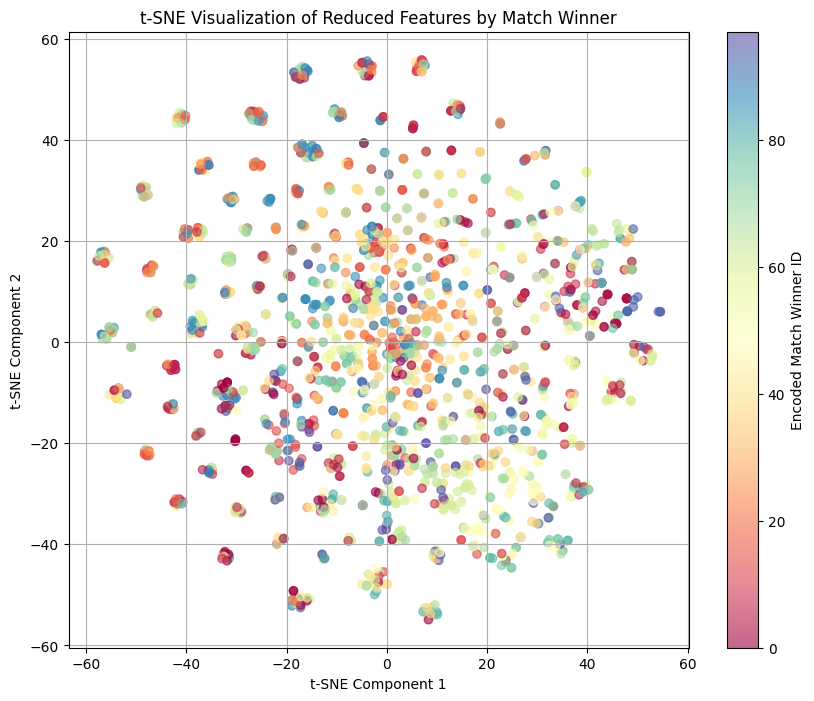

In [15]:
# CELL 3 - Dimensionality Reduction: PCA and t-SNE

# 1. Feature Preparation (Input features for DR: Team and Venue IDs)
cats = ['team1', 'team2', 'venue']
df_ohe = pd.get_dummies(dfp[cats].astype(str), prefix=cats)
X_dr = df_ohe.fillna(0)
feature_names = X_dr.columns.tolist()

# Save OHE column names and scaler for later use
with open('models/ohe_cols.pkl', 'wb') as f: pickle.dump(feature_names, f)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_dr)
with open('models/scaler.pkl', 'wb') as f: pickle.dump(scaler, f)

# 2. PCA for Dimensionality Reduction (Target 95% variance)
pca = PCA(n_components=0.95, random_state=42)
X_pca = pca.fit_transform(X_scaled)
with open('models/pca.pkl', 'wb') as f: pickle.dump(pca, f)

print(f"Original feature space: {X_dr.shape[1]} features")
print(f"Reduced PCA feature space (95% variance): {X_pca.shape[1]} components")
print(f"Cumulative Explained Variance: {np.sum(pca.explained_variance_ratio_):.4f}")

# 3. t-SNE Visualization (The 'other method' for visual clustering)
np.random.seed(42)
sample_size = min(X_pca.shape[0], 2000)
idx = np.random.choice(X_pca.shape[0], sample_size, replace=False)
X_tsne_sample = X_pca[idx, :]

if X_tsne_sample.shape[1] > 1:
    print("Starting t-SNE visualization on a sample")
    tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=500, learning_rate='auto', init='random')
    X_tsne = tsne.fit_transform(X_tsne_sample)

    le_plot_winner = LabelEncoder()
    df_plot = dfp.loc[idx].copy()
    df_plot['winner_encoded'] = le_plot_winner.fit_transform(df_plot['winner_norm'])

    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=df_plot['winner_encoded'], cmap='Spectral', alpha=0.6)
    plt.colorbar(scatter, label='Encoded Match Winner ID')
    plt.title('t-SNE Visualization of Reduced Features by Match Winner')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.grid(True)
    plt.show()
else:
    print("Not enough components after PCA to run t-SNE.")

In [16]:
# CELL 4 - Data Splitting for Three Models

# --- FIX: Filter out single-sample classes for Stratified Split ---
# This is necessary because some teams have only 1 win in the entire dataset,
# which breaks the stratified split (you need at least 2 samples per class).

# 1. Identify single-sample classes in the winner target (using a temporary encoder on all data)
le_winner_temp = LabelEncoder()
y_win_all = le_winner_temp.fit_transform(dfp['winner_norm'])
winner_counts = pd.Series(y_win_all).value_counts()
single_member_classes_encoded = winner_counts[winner_counts < 2].index.tolist()
single_member_classes_norm = le_winner_temp.inverse_transform(single_member_classes_encoded)

# Filter the main DataFrame
dfp_filtered = dfp[~dfp['winner_norm'].isin(single_member_classes_norm)].reset_index(drop=True)

# 2. Re-derive the common OHE features and feature names from the filtered data
cats = ['team1', 'team2', 'venue']
X_common_ohe = pd.get_dummies(dfp_filtered[cats].astype(str), prefix=['team1', 'team2', 'venue'])
feature_names = X_common_ohe.columns.tolist() 

# CRITICAL FIX: Save the correct feature names list for the prediction function
with open('models/ohe_cols.pkl', 'wb') as f: pickle.dump(feature_names, f)
# -------------------------------------------------------------------


# --- 1. Match Winner Data (Classification) ---
le_winner = LabelEncoder()
y_win = le_winner.fit_transform(dfp_filtered['winner_norm'])
with open('models/le_winner.pkl', 'wb') as f: pickle.dump(le_winner, f)
X_win_train, X_win_test, y_win_train, y_win_test = train_test_split(X_common_ohe, y_win, test_size=0.2, random_state=42, stratify=y_win)


# --- 2. Best Toss Decision Data (Classification) ---
toss_df = dfp_filtered[dfp_filtered['toss_decision'].isin(['bat', 'bowl'])].copy()
X_toss_full = X_common_ohe.loc[toss_df.index].copy()
# Add feature: Toss Winner (is it Team1?)
toss_winner_is_team1 = toss_df['toss_winner_id'] == toss_df['team1']
X_toss_full['toss_winner_is_team1'] = toss_winner_is_team1.astype(int)

le_toss = LabelEncoder()
y_toss = le_toss.fit_transform(toss_df['toss_decision'])
with open('models/le_toss.pkl', 'wb') as f: pickle.dump(le_toss, f)
X_toss_train, X_toss_test, y_toss_train, y_toss_test = train_test_split(X_toss_full, y_toss, test_size=0.2, random_state=42, stratify=y_toss)


# --- 3. Safe Score Data (Regression) ---
score_df = dfp_filtered.dropna(subset=['first_innings_score_num']).copy()
X_score_full = X_common_ohe.loc[score_df.index].copy()
y_score = score_df['first_innings_score_num']
X_score_train, X_score_test, y_score_train, y_score_test = train_test_split(X_score_full, y_score, test_size=0.2, random_state=42)

print(f"Data filter applied: {dfp.shape[0] - dfp_filtered.shape[0]} rows removed.")
print(f"Match Winner Data: Train={X_win_train.shape}, Test={X_win_test.shape}")
print(f"Toss Decision Data: Train={X_toss_train.shape}, Test={X_toss_test.shape}")
print(f"Safe Score Data: Train={X_score_train.shape}, Test={X_score_test.shape}")

Data filter applied: 10 rows removed.
Match Winner Data: Train=(2064, 425), Test=(517, 425)
Toss Decision Data: Train=(2064, 426), Test=(517, 426)
Safe Score Data: Train=(2064, 425), Test=(517, 425)


In [17]:
# CELL 5 - Model 1: Match Winner Prediction (GradientBoostingClassifier)

# Goal: Predicted match winner using past head to head data of the same teams in same venue.
print("--- ACCURACY COMPARISON: DEFAULT vs. TUNED GRADIENT BOOSTING ---")
# -------------------------------------------------------------
# PART 1: ACCURACY BEFORE TUNING (Using Default Parameters)
# -------------------------------------------------------------

# Initialize with DEFAULT parameters and train
default_model_win = GradientBoostingClassifier(random_state=42)
default_model_win.fit(X_win_train, y_win_train)

# Evaluate performance on the test set
y_pred_default_win = default_model_win.predict(X_win_test)
accuracy_default_win = accuracy_score(y_win_test, y_pred_default_win)

print(f"1. Accuracy BEFORE Tuning (Default): {accuracy_default_win:.4f}")
print("-" * 55)

# -------------------------------------------------------------
# PART 2: HYPERPARAMETER TUNING (GridSearchCV)
# -------------------------------------------------------------

model_win = GradientBoostingClassifier(random_state=42)

# Using a smaller parameter grid to significantly reduce execution time (fewer than 36 fits)
param_grid_win = {
    'n_estimators': [50, 100],      # Reduced search space
    'learning_rate': [0.1],         # Using only one value
    'max_depth': [3, 5]
}

print("Starting GridSearchCV for Match Winner Prediction...")
grid_search_win = GridSearchCV(
    estimator=model_win, 
    param_grid=param_grid_win, 
    cv=3, 
    scoring='accuracy', 
    n_jobs=-1, 
    verbose=1
)
grid_search_win.fit(X_win_train, y_win_train)
best_model_win = grid_search_win.best_estimator_

# Evaluation
y_win_pred_tuned = best_model_win.predict(X_win_test)
accuracy_tuned_win = accuracy_score(y_win_test, y_win_pred_tuned)

# -------------------------------------------------------------
# PART 3: FINAL REPORTING
# -------------------------------------------------------------

print(f"\nModel 1: Match Winner (GradientBoostingClassifier)")
print(f"Best Parameters: {grid_search_win.best_params_}")

# Comparing the tuned accuracy to the default accuracy
print(f"2. Accuracy AFTER Tuning (Best Model): {accuracy_tuned_win:.4f}")
print("-" * 55)

# Report Generation
unique_labels = np.unique(y_win_test)
report_target_names = le_winner.inverse_transform(unique_labels)
print(f"Classification Report:\n{classification_report(y_win_test, y_win_pred_tuned, labels=unique_labels, target_names=report_target_names, zero_division=0)}")

# Save the best model
with open('models/best_model_winner.pkl', 'wb') as f: pickle.dump(best_model_win, f)

--- ACCURACY COMPARISON: DEFAULT vs. TUNED GRADIENT BOOSTING ---
1. Accuracy BEFORE Tuning (Default): 0.5803
-------------------------------------------------------
Starting GridSearchCV for Match Winner Prediction...
Fitting 3 folds for each of 4 candidates, totalling 12 fits

Model 1: Match Winner (GradientBoostingClassifier)
Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}
2. Accuracy AFTER Tuning (Best Model): 0.5803
-------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.81      0.79        16
           1       0.50      0.50      0.50         2
          10       0.00      0.00      0.00         1
         100       0.92      0.79      0.85        14
         101       0.60      1.00      0.75         3
         102       0.43      0.38      0.40        16
         104       0.33      0.33      0.33         9
         105       0.00      0.00   

In [18]:
# CELL 6 - Model 2: Best Toss Decision Prediction (RandomForestClassifier)

# Goal: Predicted best toss decision using past match outcomes relation with toss outcome.
model_toss = RandomForestClassifier(random_state=42)
param_grid_toss = {
    'n_estimators': [50, 100, 150],
    'max_depth': [5, 10],
    'class_weight': ['balanced', None]
}

print("Starting GridSearchCV for Toss Decision Prediction...")
grid_search_toss = GridSearchCV(estimator=model_toss, param_grid=param_grid_toss, cv=3, scoring='f1_weighted', n_jobs=-1, verbose=1)
grid_search_toss.fit(X_toss_train, y_toss_train)
best_model_toss = grid_search_toss.best_estimator_

# Evaluation
y_toss_pred = best_model_toss.predict(X_toss_test)
print(f"\nModel 2: Best Toss Decision (RandomForestClassifier)")
print(f"Best Parameters: {grid_search_toss.best_params_}")
print(f"Test Accuracy: {accuracy_score(y_toss_test, y_toss_pred):.4f}")
print(f"Classification Report:\n{classification_report(y_toss_test, y_toss_pred, target_names=le_toss.classes_, zero_division=0)}")

# Save the best model
with open('models/best_model_toss.pkl', 'wb') as f: pickle.dump(best_model_toss, f)

Starting GridSearchCV for Toss Decision Prediction...
Fitting 3 folds for each of 12 candidates, totalling 36 fits

Model 2: Best Toss Decision (RandomForestClassifier)
Best Parameters: {'class_weight': 'balanced', 'max_depth': 5, 'n_estimators': 100}
Test Accuracy: 0.9942
Classification Report:
              precision    recall  f1-score   support

         bat       0.99      1.00      0.99       244
        bowl       1.00      0.99      0.99       273

    accuracy                           0.99       517
   macro avg       0.99      0.99      0.99       517
weighted avg       0.99      0.99      0.99       517



In [19]:
# CELL 7 - Model 3: Safe Score Prediction (RandomForestRegressor)

# Goal: Safe score for first batting team by past match outcomes relation with teams scores.
model_score = RandomForestRegressor(random_state=42)
param_grid_score = {
    'n_estimators': [50, 100, 150],
    'max_depth': [5, 10],
    'min_samples_split': [5, 10]
}

print("Starting GridSearchCV for Safe Score Prediction...")
grid_search_score = GridSearchCV(estimator=model_score, param_grid=param_grid_score, cv=3, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=1)
grid_search_score.fit(X_score_train, y_score_train)
best_model_score = grid_search_score.best_estimator_

# Evaluation
y_score_pred = best_model_score.predict(X_score_test)
mae = mean_absolute_error(y_score_test, y_score_pred)
rmse = np.sqrt(mean_squared_error(y_score_test, y_score_pred))
r2 = r2_score(y_score_test, y_score_pred)

print(f"\nModel 3: Safe Score (RandomForestRegressor)")
print(f"Best Parameters: {grid_search_score.best_params_}")
print(f"Test MAE: {mae:.2f}") # Mean Absolute Error: The average error in runs
print(f"Test RMSE: {rmse:.2f}")
print(f"Test R-squared: {r2:.4f}")

# Save the best model
with open('models/best_model_score.pkl', 'wb') as f: pickle.dump(best_model_score, f)

Starting GridSearchCV for Safe Score Prediction...
Fitting 3 folds for each of 12 candidates, totalling 36 fits

Model 3: Safe Score (RandomForestRegressor)
Best Parameters: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 150}
Test MAE: 23.73
Test RMSE: 30.57
Test R-squared: 0.0767


In [20]:
# CELL 8 - Final Prediction Helper Function

# Reload all saved components
try:
    with open('models/ohe_cols.pkl', 'rb') as f: feature_names = pickle.load(f)
    with open('models/le_winner.pkl', 'rb') as f: le_winner = pickle.load(f)
    with open('models/le_toss.pkl', 'rb') as f: le_toss = pickle.load(f)
    with open('models/best_model_winner.pkl', 'rb') as f: best_model_win = pickle.load(f)
    with open('models/best_model_toss.pkl', 'rb') as f: best_model_toss = pickle.load(f)
    with open('models/best_model_score.pkl', 'rb') as f: best_model_score = pickle.load(f)
    print("\nAll models and transformers loaded successfully for prediction.")
except FileNotFoundError as e:
    print(f"Error loading required files: {e}. Please ensure you have run all training cells (5, 6, 7).")
    feature_names = None

def get_feature_vector(team1, team2, venue, is_toss_winner_team1=True):
    """Creates the one-hot encoded feature vector for a new match."""
    if feature_names is None: return None, None
    
    input_data = pd.DataFrame([{'team1': str(team1), 'team2': str(team2), 'venue': str(venue)}])
    
    # One-Hot Encode the match data
    input_ohe = pd.get_dummies(input_data[['team1', 'team2', 'venue']], prefix=['team1', 'team2', 'venue'])
    
    # Reindex and fill with 0 to match training column structure (CRITICAL STEP)
    X_pred_common = input_ohe.reindex(columns=feature_names, fill_value=0)
    
    # Feature set for Winner/Score models
    X_win_score = X_pred_common 
    
    # Feature set for Toss model (requires the 'toss_winner_is_team1' feature)
    X_toss = X_pred_common.copy() 
    X_toss['toss_winner_is_team1'] = 1 if is_toss_winner_team1 else 0 
    
    return X_win_score, X_toss


def predict_all(team1, team2, venue):
    """Predicts Match Winner, Best Toss Decision, and Safe Score."""
    if feature_names is None: 
        return {"Error": "Models and feature names failed to load."} 
    
    print(f"\n--- Prediction for Match: Team ID {team1} vs Team ID {team2} at Venue ID {venue} ---")
    
    # Get feature vectors (T1 toss winner case is used for common features)
    X_win_score, X_toss_t1 = get_feature_vector(team1, team2, venue, is_toss_winner_team1=True)
    
    # 1. Predicted Match Winner
    win_pred_encoded = best_model_win.predict(X_win_score)[0]
    predicted_winner_id = le_winner.inverse_transform([win_pred_encoded])[0]
    
    # 3. Predicted Safe Score
    safe_score_pred = best_model_score.predict(X_win_score)[0]
    
    # 2. Predicted Best Toss Decision
    # Scenario 1: T1 wins the toss
    toss_prob_t1 = best_model_toss.predict_proba(X_toss_t1)[0]
    toss_decision_t1 = le_toss.inverse_transform([np.argmax(toss_prob_t1)])[0]
    prob_t1 = np.max(toss_prob_t1)
    
    # Scenario 2: T2 wins the toss
    X_win_score_unused, X_toss_t2 = get_feature_vector(team1, team2, venue, is_toss_winner_team1=False)
    toss_prob_t2 = best_model_toss.predict_proba(X_toss_t2)[0]
    toss_decision_t2 = le_toss.inverse_transform([np.argmax(toss_prob_t2)])[0]
    prob_t2 = np.max(toss_prob_t2)
    
    # Composite recommendation covering both scenarios
    predicted_toss_decision = f"If Team {team1} wins the toss: Choose {toss_decision_t1.upper()} ({prob_t1*100:.1f}% confidence). If Team {team2} wins the toss: Choose {toss_decision_t2.upper()} ({prob_t2*100:.1f}% confidence)."
    
    # Final Output
    result = {
        "1) Predicted Match Winner": f"Team ID {predicted_winner_id}",
        "2) Predicted Best Toss Decision": predicted_toss_decision,
        "3) Predicted Safe Score for First Batting Team": f"{int(round(safe_score_pred))} Runs",
        "Note": "Team and venue IDs must be mapped back to names using your original dataset's mapping."
    }
    
    return result

# Example Usage (Use IDs from your CSV, e.g., '41', '2', '118' from the first row)
print(predict_all('41', '2', '118'))


All models and transformers loaded successfully for prediction.

--- Prediction for Match: Team ID 41 vs Team ID 2 at Venue ID 118 ---
{'1) Predicted Match Winner': 'Team ID 41', '2) Predicted Best Toss Decision': 'If Team 41 wins the toss: Choose BAT (56.3% confidence). If Team 2 wins the toss: Choose BOWL (62.6% confidence).', '3) Predicted Safe Score for First Batting Team': '130 Runs', 'Note': "Team and venue IDs must be mapped back to names using your original dataset's mapping."}
